In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import kernels as ker

In [11]:
params = {'legend.fontsize': 12,
         'axes.labelsize': 10,
         'axes.titlesize': 12,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
pylab.rcParams.update(params)

In [3]:
class AlphaKernelRidge:
    
    def __init__(self, kernel, sigma=1.0, c=1.0, alpha=1.0, B=1.0, delta=0.01):
        self.kernel = kernel
        self.sigma = sigma
        self.c = c
        self.alpha = alpha
        self.B = B
        self.delta = delta
    
    def fit(self, x, y):
        alpha = self.sigma**2/self.c
        self.x = x
        self.y = y
        self.k_nn = self.kernel(x, x)
        self.kinv = np.linalg.inv(self.k_nn + self.alpha*np.eye(n))
        kinv_c = np.linalg.inv(self.k_nn + alpha*np.eye(n))
        logdet = np.linalg.slogdet(self.k_nn/alpha + np.eye(n))[1]
        quad_a = self.alpha*np.dot(y.reshape(-1), np.dot(self.kinv, y.reshape(-1)))
        quad_c = alpha*np.dot(y.reshape(-1), np.dot(kinv_c, y.reshape(-1)))
        R_sq = self.sigma**2*logdet + 2*self.sigma**2*np.log(1/self.delta) + self.alpha*self.B**2 + \
        quad_c - quad_a
        self.R = np.sqrt(R_sq)
    
    def predict(self, x):
        k = self.kernel(x, self.x)
        mid = np.matmul(k, np.matmul(self.kinv, self.y))
        sigma = np.diag(self.kernel(x, x)).reshape(mid.shape) - \
        np.diag(np.matmul(k, np.matmul(self.kinv, k.T))).reshape(mid.shape)
        lcb = mid - (self.R/math.sqrt(self.alpha))*np.sqrt(sigma)
        ucb = mid + (self.R/math.sqrt(self.alpha))*np.sqrt(sigma)
        return mid, lcb, ucb

In [20]:
kernel = ker.Matern52Kernel(0.5)

n = 10
d = 1
m = 10
B = 10.0
sigma = 0.1
c = 1.0
delta = 0.01

a = -1.0
b = 1.0

runs = 3

alpha_0 = 1e-4
alpha_T = 2.0
grid_size = 200
base = math.exp((math.log(alpha_T) - math.log(alpha_0))/(grid_size-1))
alphas = alpha_0*base**np.arange(0, grid_size)

ucbs = np.zeros((runs, grid_size))
for i in range(runs):
    func = ker.RKHSFunc(kernel, a, b, d, m, B)
    x = np.random.uniform(a, b, (n, 1))
    y = func(x) + np.random.normal(0.0, sigma, (n, 1))
    x_test = np.random.uniform(a, b, (1,1))
    for j in range(alphas.shape[0]):
        model = AlphaKernelRidge(kernel, sigma, c, alphas[j], B, delta)
        model.fit(x, y)
        y_hat, lcb, ucb = model.predict(x_test)
        ucbs[i][j] = ucb[0][0]

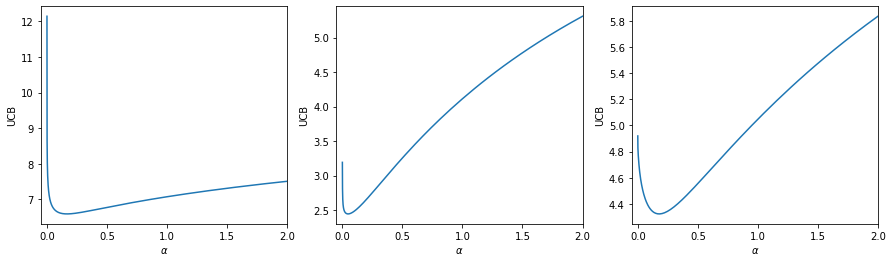

In [23]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=runs)
for i in range(runs):
    ax[i].plot(alphas, ucbs[i])
    ax[i].set_xlim([-0.05, 2.0])
    ax[i].set_xlabel(r'$\alpha$')
    ax[i].set_ylabel('UCB')
plt.savefig("figures/quasiconvex.pdf")
plt.show()